/home/rgautham20/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[INFO] [1728939553.882861529] [rosbag2_storage]: Opened database '/home/rgautham20/lab3/stationarydata.bag/stationarydata.bag_0.db3' for READ_ONLY.


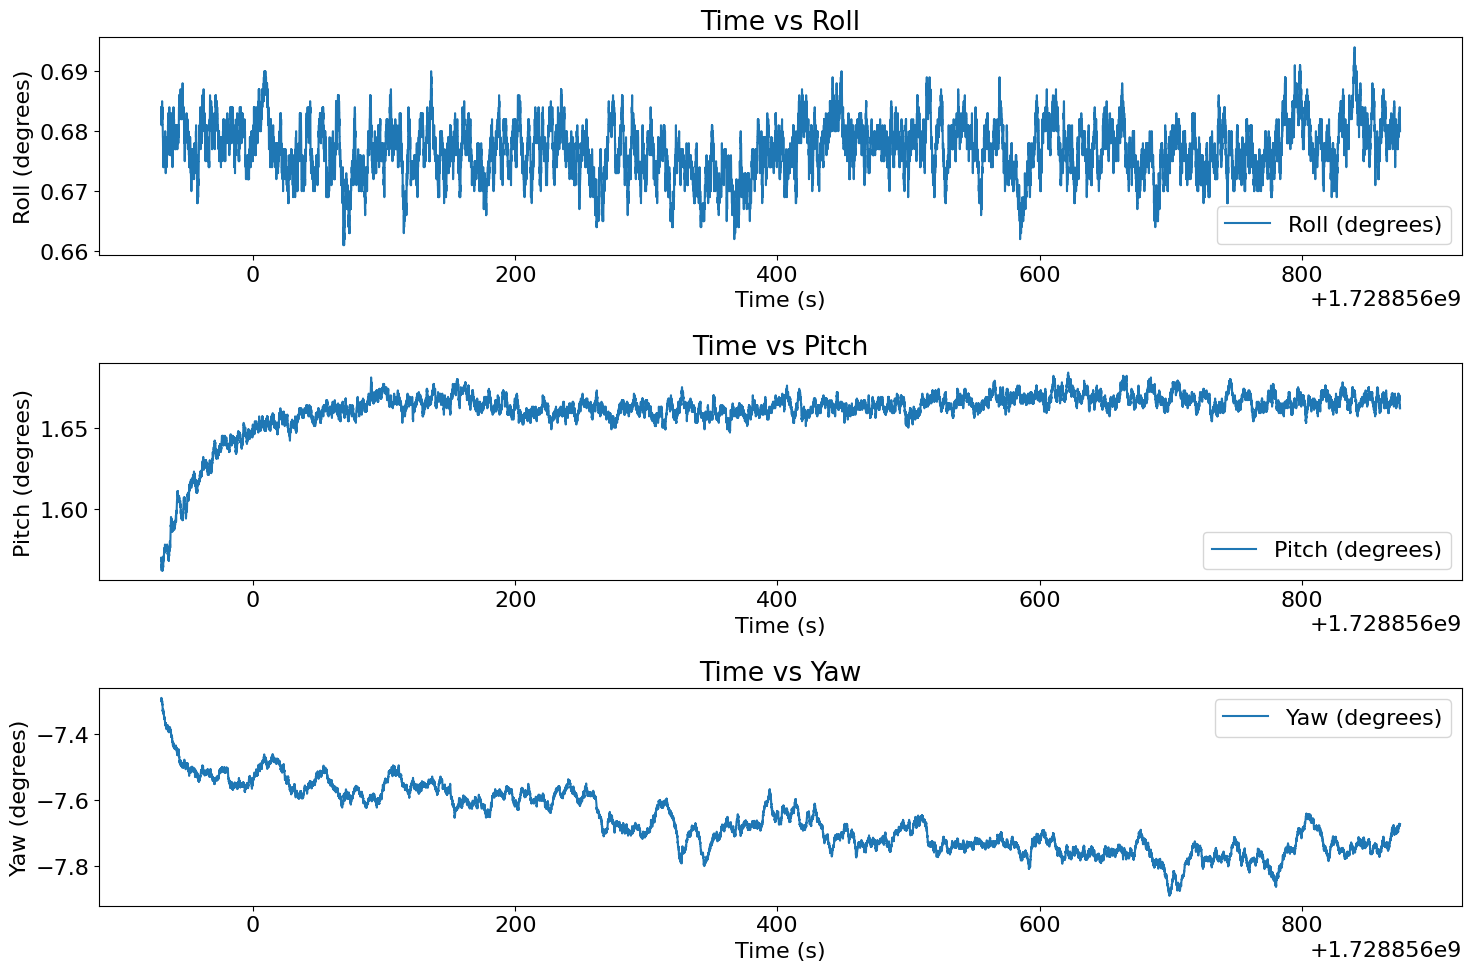

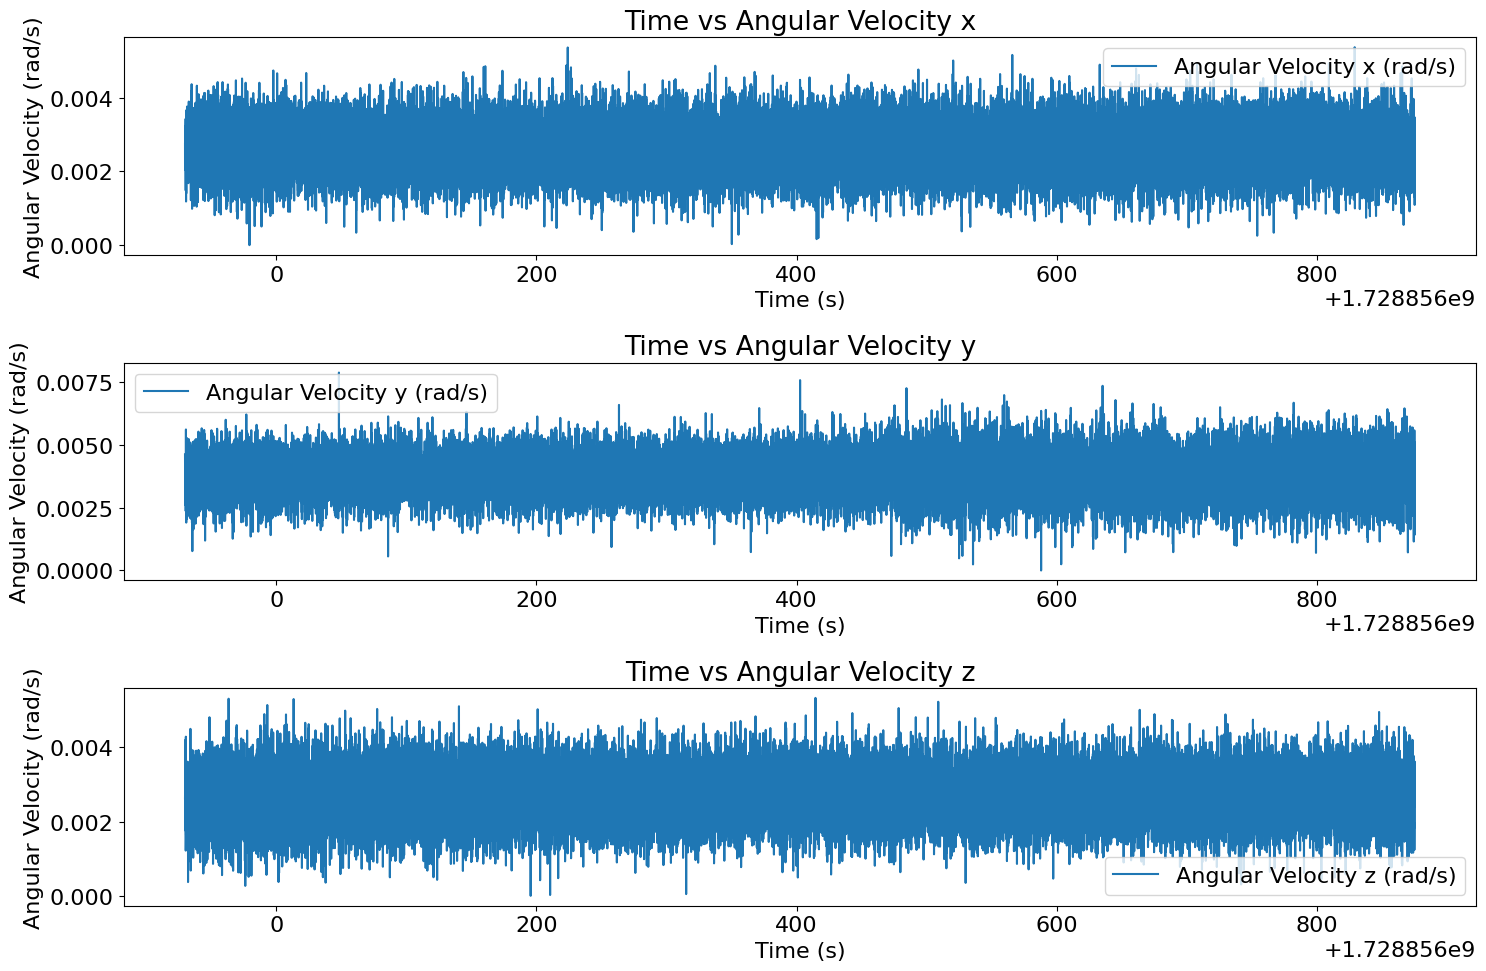

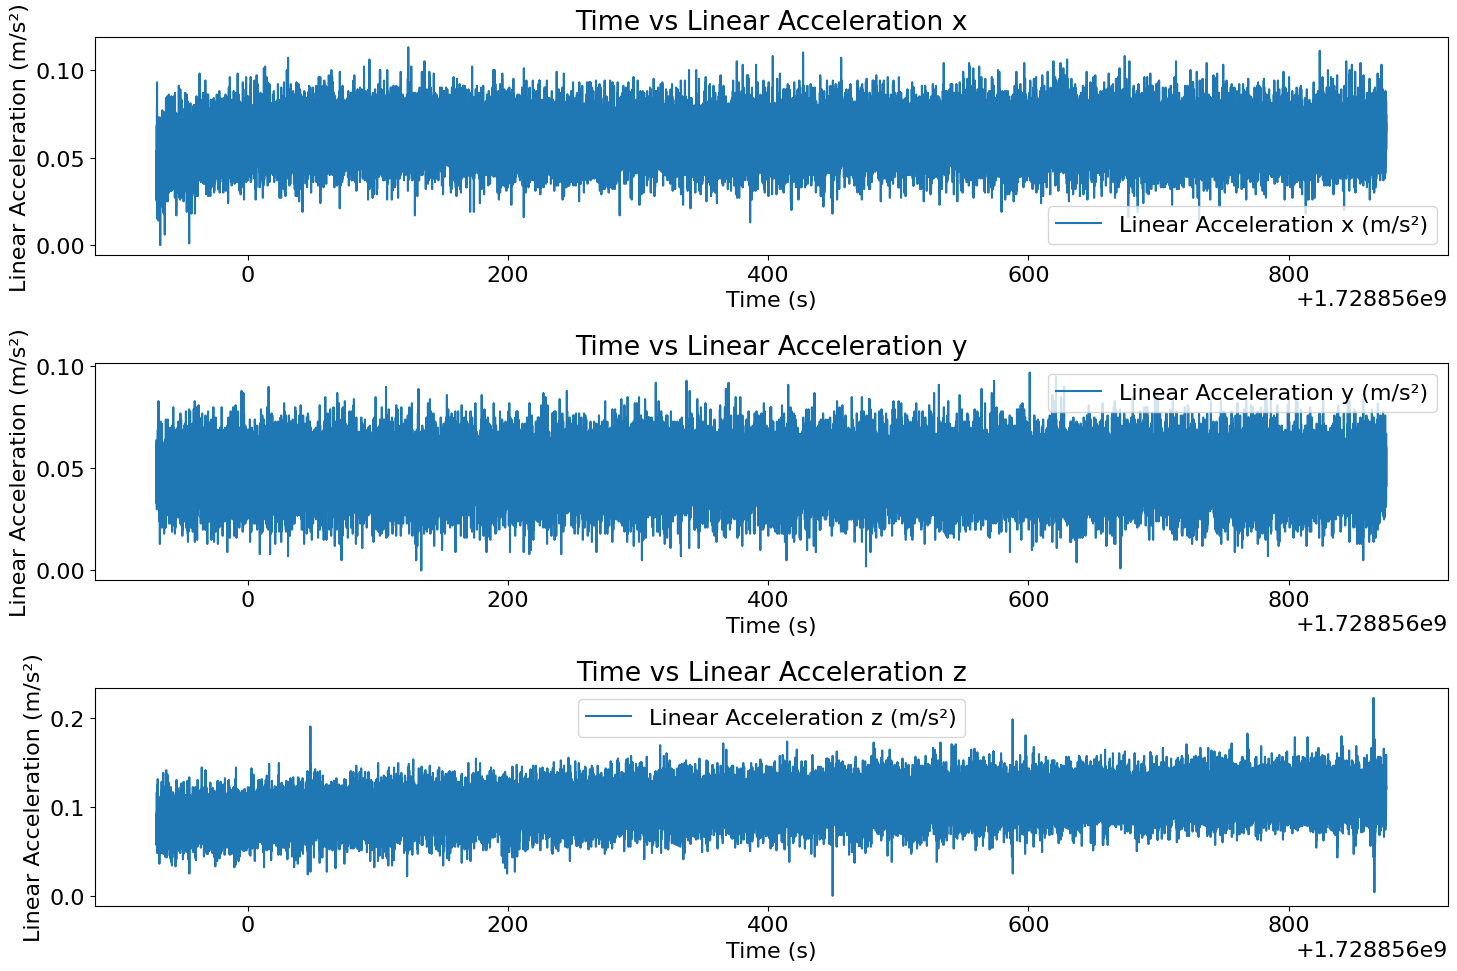

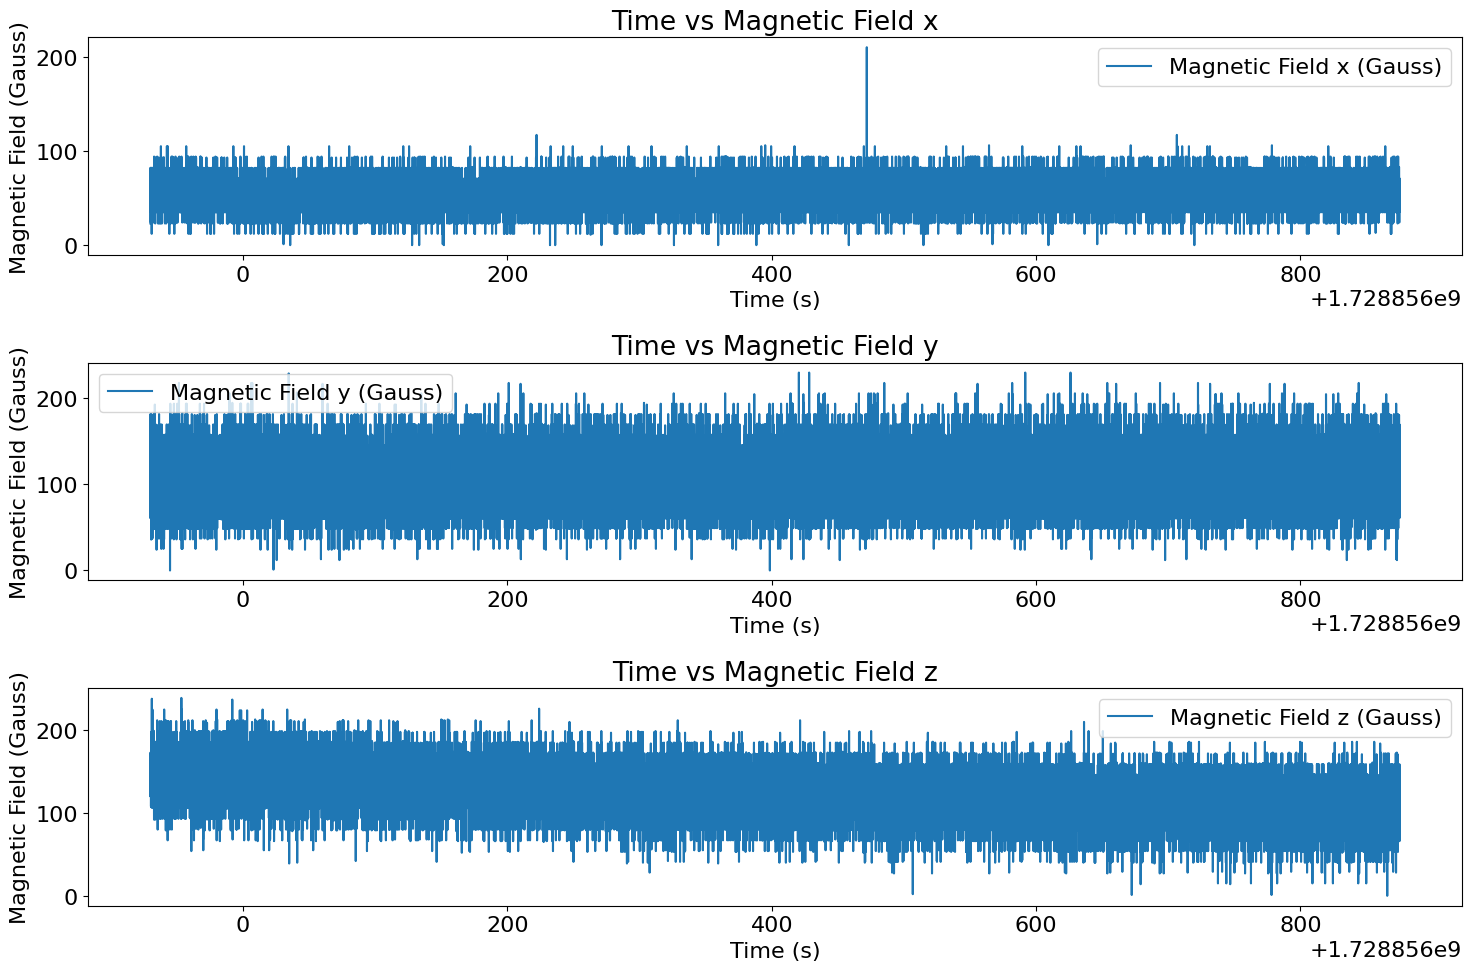

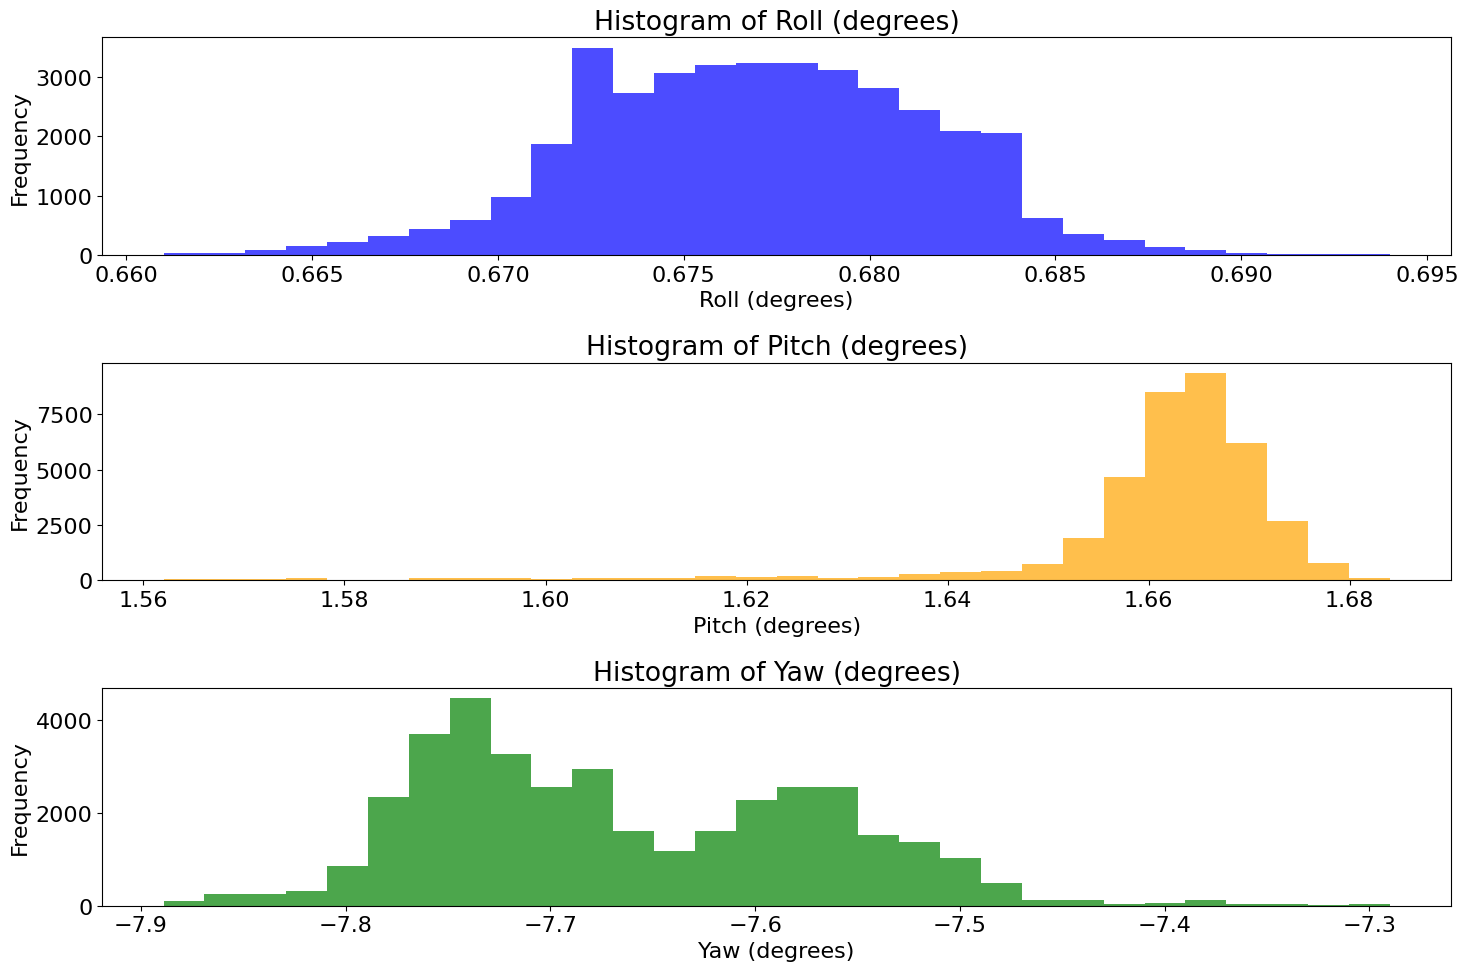

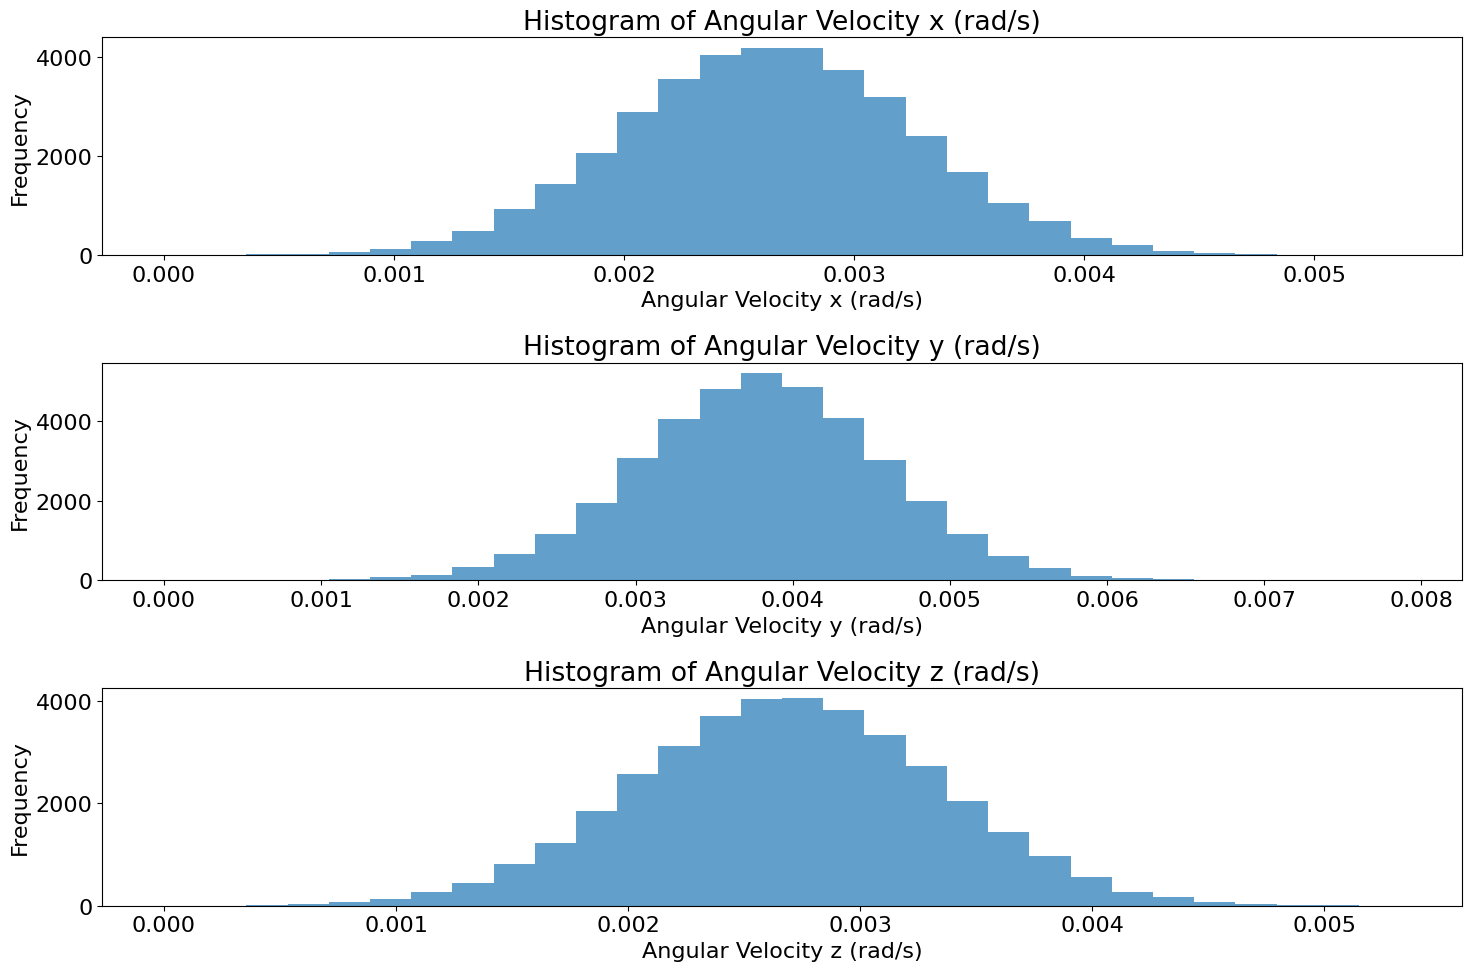

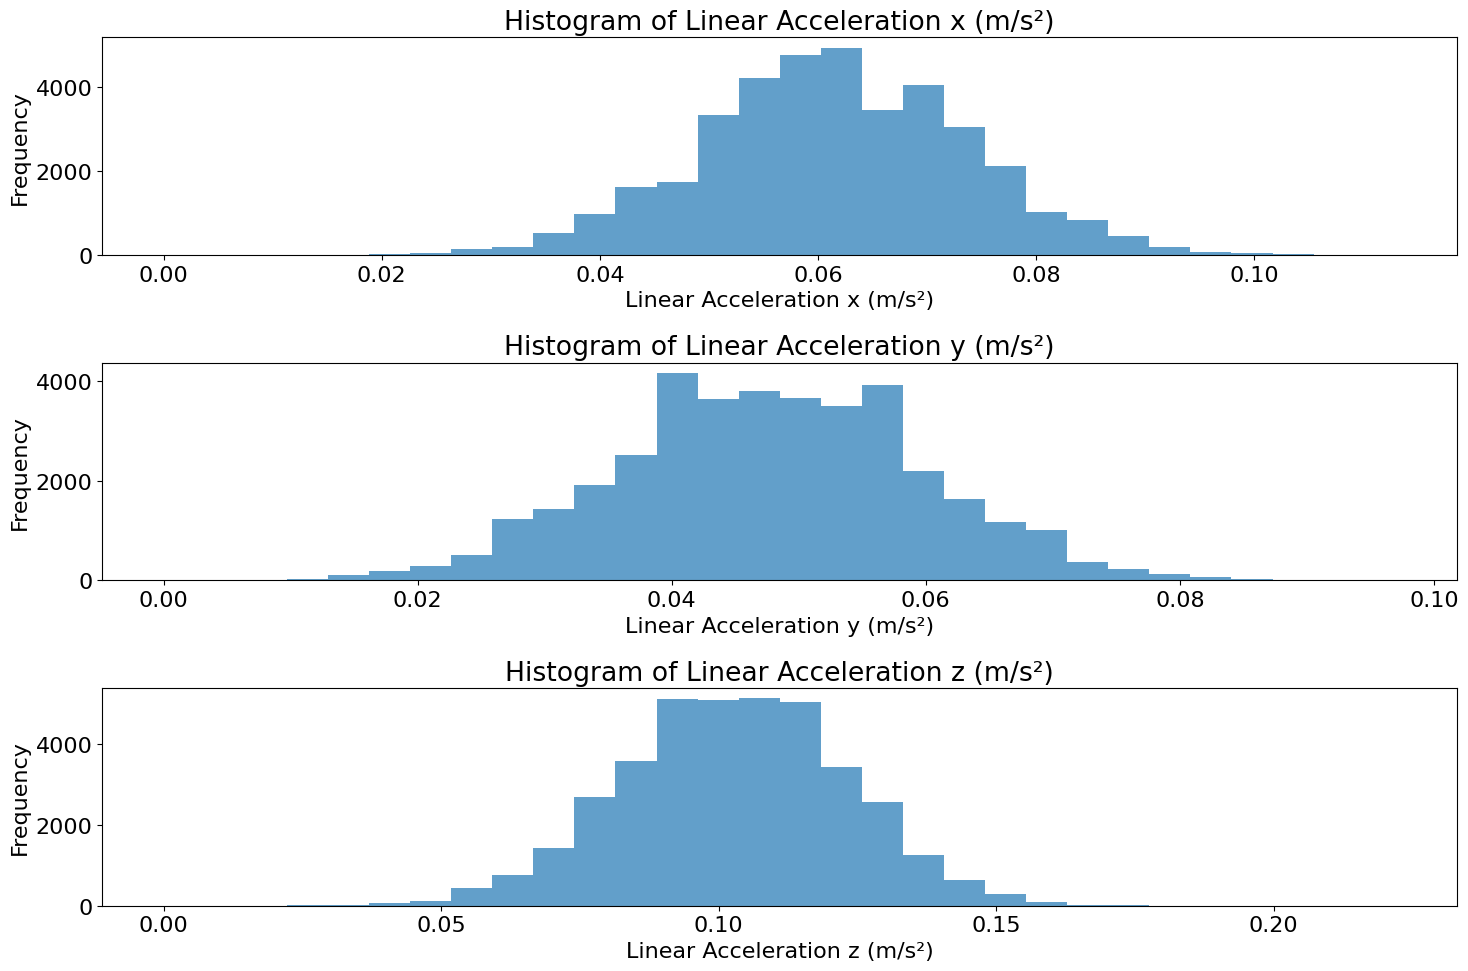

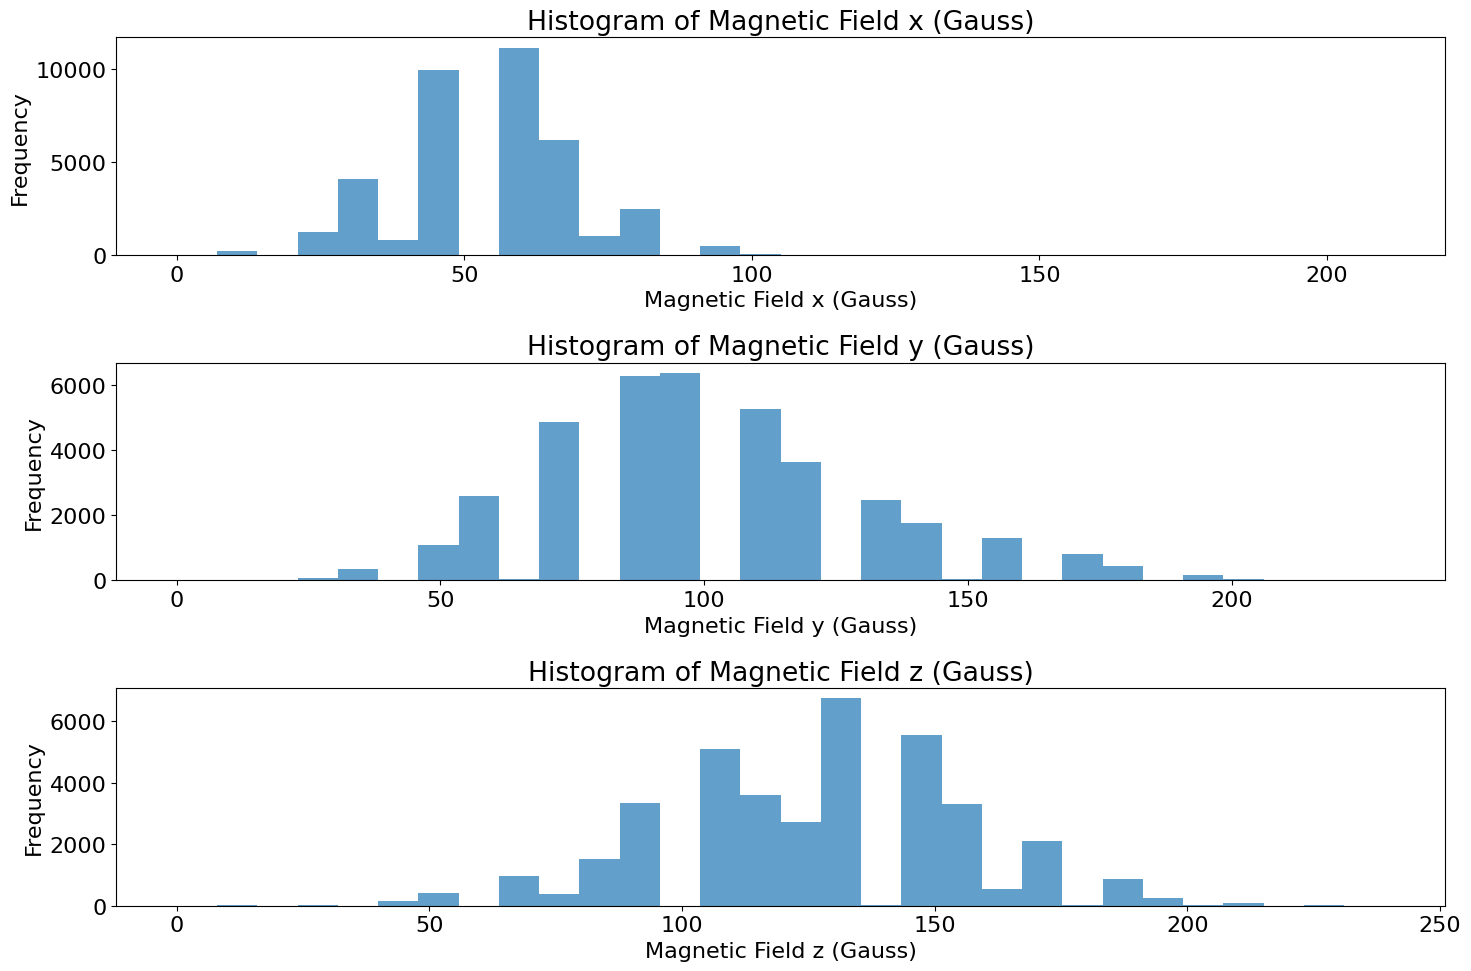

In [1]:
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

plt.rcParams.update({'font.size': 16})

def read_ros2_bag(bag_file_path, topic_name):
    storage_options = rosbag2_py.StorageOptions(uri=bag_file_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions('', '')
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    type_name = reader.get_all_topics_and_types()[0].type
    msg_type = get_message(type_name)
    messages = []

    while reader.has_next():
        (topic, data, timestamp) = reader.read_next()
        if topic == topic_name:
            msg = deserialize_message(data, msg_type)
            messages.append(msg)
    return messages

# Specify the bag file path and topic
bag_file_path = '/home/rgautham20/lab3/stationarydata.bag/stationarydata.bag_0.db3'
topic_name = '/imu'

# Read messages from the bag
messages = read_ros2_bag(bag_file_path, topic_name)

# Convert to pandas DataFrame
data = {
    'Time': [],
    'orientation_w': [],
    'orientation_x': [],
    'orientation_y': [],
    'orientation_z': [],
    'angular_velocity_x': [],
    'angular_velocity_y': [],
    'angular_velocity_z': [],
    'linear_acceleration_x': [],
    'linear_acceleration_y': [],
    'linear_acceleration_z': [],
    'magnetic_field_x': [],
    'magnetic_field_y': [],
    'magnetic_field_z': []
}

for msg in messages:
    data['Time'].append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
    data['orientation_w'].append(msg.imu.orientation.w)
    data['orientation_x'].append(msg.imu.orientation.x)
    data['orientation_y'].append(msg.imu.orientation.y)
    data['orientation_z'].append(msg.imu.orientation.z)
    data['angular_velocity_x'].append(msg.imu.angular_velocity.x)
    data['angular_velocity_y'].append(msg.imu.angular_velocity.y)
    data['angular_velocity_z'].append(msg.imu.angular_velocity.z)
    data['linear_acceleration_x'].append(msg.imu.linear_acceleration.x)
    data['linear_acceleration_y'].append(msg.imu.linear_acceleration.y)
    data['linear_acceleration_z'].append(msg.imu.linear_acceleration.z)
    # Convert magnetic field from Tesla to Gauss
    data['magnetic_field_x'].append(msg.mag_field.magnetic_field.x * 10000)  # Tesla to Gauss
    data['magnetic_field_y'].append(msg.mag_field.magnetic_field.y * 10000)  # Tesla to Gauss
    data['magnetic_field_z'].append(msg.mag_field.magnetic_field.z * 10000)  # Tesla to Gauss

readings = pd.DataFrame(data)

# Normalize IMU data to start from zero
imu_fields = [
    'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z',
    'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z'
]
for field in imu_fields:
    readings[field] = readings[field] - readings[field].min()

mag_fields = ['magnetic_field_x', 'magnetic_field_y', 'magnetic_field_z']
for field in mag_fields:
    readings[field] = readings[field] - readings[field].min()

# Convert orientation from quaternion to roll, pitch, yaw
w = readings['orientation_w']
x = readings['orientation_x']
y = readings['orientation_y']
z = readings['orientation_z']

t0 = +2.0 * (w * x + y * z)
t1 = +1.0 - 2.0 * (x * x + y * y)
roll_x = np.degrees(np.arctan2(t0, t1))

t2 = +2.0 * (w * y - z * x)
t2 = np.where(t2 > +1.0, +1.0, t2)
t2 = np.where(t2 < -1.0, -1.0, t2)
pitch_y = np.degrees(np.arcsin(t2))

t3 = +2.0 * (w * z + x * y)
t4 = +1.0 - 2.0 * (y * y + z * z)
yaw_z = np.degrees(np.arctan2(t3, t4))

# Plot roll, pitch, yaw vs time
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.plot(readings['Time'], roll_x, label='Roll (degrees)')
plt.title('Time vs Roll')
plt.xlabel('Time (s)')
plt.ylabel('Roll (degrees)')
plt.legend()

plt.subplot(312)
plt.plot(readings['Time'], pitch_y, label='Pitch (degrees)')
plt.title('Time vs Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (degrees)')
plt.legend()

plt.subplot(313)
plt.plot(readings['Time'], yaw_z, label='Yaw (degrees)')
plt.title('Time vs Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.tight_layout()
plt.show()

# Angular velocity (x, y, z) vs time
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.plot(readings['Time'], readings[f'angular_velocity_{axis}'], label=f'Angular Velocity {axis} (rad/s)')
    plt.title(f'Time vs Angular Velocity {axis}')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.legend()
plt.tight_layout()
plt.show()

# Linear acceleration (x, y, z) vs time
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.plot(readings['Time'], readings[f'linear_acceleration_{axis}'], label=f'Linear Acceleration {axis} (m/s²)')
    plt.title(f'Time vs Linear Acceleration {axis}')
    plt.xlabel('Time (s)')
    plt.ylabel('Linear Acceleration (m/s²)')
    plt.legend()
plt.tight_layout()
plt.show()

# Magnetic field (x, y, z) vs time
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.plot(readings['Time'], readings[f'magnetic_field_{axis}'], label=f'Magnetic Field {axis} (Gauss)')
    plt.title(f'Time vs Magnetic Field {axis}')
    plt.xlabel('Time (s)')
    plt.ylabel('Magnetic Field (Gauss)')
    plt.legend()
plt.tight_layout()
plt.show()

# Histograms for roll, pitch, yaw
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.hist(roll_x, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Roll (degrees)')
plt.xlabel('Roll (degrees)')
plt.ylabel('Frequency')

plt.subplot(312)
plt.hist(pitch_y, bins=30, color='orange', alpha=0.7)
plt.title('Histogram of Pitch (degrees)')
plt.xlabel('Pitch (degrees)')
plt.ylabel('Frequency')

plt.subplot(313)
plt.hist(yaw_z, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Yaw (degrees)')
plt.xlabel('Yaw (degrees)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histograms for angular velocity
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.hist(readings[f'angular_velocity_{axis}'], bins=30, alpha=0.7)
    plt.title(f'Histogram of Angular Velocity {axis} (rad/s)')
    plt.xlabel(f'Angular Velocity {axis} (rad/s)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histograms for linear acceleration
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.hist(readings[f'linear_acceleration_{axis}'], bins=30, alpha=0.7)
    plt.title(f'Histogram of Linear Acceleration {axis} (m/s²)')
    plt.xlabel(f'Linear Acceleration {axis} (m/s²)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histograms for magnetic field
plt.figure(figsize=(15, 10))
for i, axis in enumerate(['x', 'y', 'z'], start=1):
    plt.subplot(3, 1, i)
    plt.hist(readings[f'magnetic_field_{axis}'], bins=30, alpha=0.7)
    plt.title(f'Histogram of Magnetic Field {axis} (Gauss)')
    plt.xlabel(f'Magnetic Field {axis} (Gauss)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
